# Machine Learning Model that predicts flight delays
This is a binary classification model that predicts whether a flight will arrive on-time or late ("binary" because there are only two possible outputs).
<br> It utilizes:
- Pandas to clean and prepare data
- Scikit-learn to build a machine-learning model
- Matplotlib to visualize the results
<br>It uses one Scikit-learn's RandomForestClassifier, which fits multiple decision trees to the data and uses averaging to boost the overall accuracy and limit overfitting. It is one of the several classifers in Scikit-learn for implementing common machine learning models.

**Import all the stuff we need**

In [92]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

**Import dataset**

In [5]:
#This is a Linux Bash command that downloads an CSV file from Azure Blob Storage and saves it using given name
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  3 1552k    3 48746    0     0  11262      0  0:02:21  0:00:04  0:02:17 11426
  8 1552k    8  127k    0     0  24309      0  0:01:05  0:00:05  0:01:00 25967
 12 1552k   12  191k    0     0  31083      0  0:00:51  0:00:06  0:00:45 39741
 14 1552k   14  223k    0     0  31378      0  0:00:50  0:00:07  0:00:43 45794
 18 1552k   18  287k    0     0  35363      0  0:00:44  0:00:08  0:00:36 60597
 22 1552k   22  351k    0     0  38726      0  0:00

**Load Dataset**

In [6]:


#Create a Panda DataFrame - a two-dimensional labeled data structure
df = pd.read_csv('flightdata.csv')
df.head() # The DataFrame head function only returns the first five rows

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [7]:
#gives (rows,columns) count
df.shape 

(5442, 26)

## Clean and Prepare the data

In [8]:
#Check for any missing values, if true then there are null values 
df.isnull().values.any()



True

In [9]:
#Function finds the mising values and shows number of missing values in each column 
df.isnull().sum()


YEAR                      0
QUARTER                   0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
UNIQUE_CARRIER            0
TAIL_NUM                  0
FL_NUM                    0
ORIGIN_AIRPORT_ID         0
ORIGIN                    0
DEST_AIRPORT_ID           0
DEST                      0
CRS_DEP_TIME              0
DEP_TIME                 43
DEP_DELAY                43
DEP_DEL15                43
CRS_ARR_TIME              0
ARR_TIME                 46
ARR_DELAY                83
ARR_DEL15                83
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME          1
ACTUAL_ELAPSED_TIME      84
DISTANCE                  1
Unnamed: 25            5442
dtype: int64

In [10]:
#Filter out all the irrelevant columns so that you are only left with relevant features

#Fuction will remove the 26th column which has 11231 missing values because 
#it only contains commas usually found at the end of every line of CSV
df.drop('Unnamed: 25',axis=1)

#Filter out all the other columns so that you are only left with those relevant to the predictive model
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum() #Check if they have been removed

MONTH            0
DAY_OF_MONTH     0
DAY_OF_WEEK      0
ORIGIN           0
DEST             0
CRS_DEP_TIME     0
ARR_DEL15       83
dtype: int64

In [11]:
df[df.isnull().values.any(axis=1)].head()
#The null(Nan) values in ARR_DEL15 correspond to flights that were diverted or canceled

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


In [12]:
#The fillna method fills all the null values with one to indicate taht there late by more than 15 minutes
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

#The missing values have been replaced and the list of columns has been narrowed to those most relevant to the model

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


In [13]:
#The CRS_DEP_TIME column contains 500 unique values...
#Performing binning or quantization leaves a maximum of 24 discrete values 

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


In [14]:
#Generate indicator columns from the ORIGIN and DEST columns, while dropping the ORIGIN and DEST columns themselves
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


## Build Machine Learning Model
Before training the model with the Random Forest classifier we:
- Split the DataFrame into a training set containing 80% of the original data, and a test set containing the remaining 20% using the sklearn train_test_split helper function. 
- Separate the DataFrame into input feature columns and output label columns.

In [15]:
#Split the the dataset into two, that is, training and testing set.
#Separate the feature columns and label columns. 
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [16]:
#Create a RandomForestClassifier object and train it by calling the fit method.
#The default values of the classifier can be overriden when creating the RandomForestClassifier object.
model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

C:\Users\Sandra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [17]:
#Call the predict method to test the model
predicted = model.predict(test_x)

#Determine the mean accuracy of the model using the score method
model.score(test_x, test_y)

0.8833792470156107

## Determing accuracy further
The **mean accuracy** is 86%(calculated above) isn't always a reliable indicator of the accuracy of a classification model. 
<br>The score method reflects how many flights were predicted correctly. This score is skewed by the fact that our dataset contains many more rows representing on-time arrivals than rows representing late arrivals.
<br>A better overall measure for a binary classification model is **Area Under Receiver Operating Characteristic Curve** (sometimes referred to as "ROC AUC"), which essentially quantifies how often the model will make a correct prediction regardless of the outcome.
<br>Before computing the ROC AUC, we must generate prediction probabilities for the test set. These probabilities are estimates for each of the classes, or answers, the model can predict.
<br>Other measures of accuracy for a classification model include **precision and recall**. We'll use Scikit-learn  precision_score and recall_score methods for computing precision and recall respectively.

In [18]:
#Generate a set of prediction probabilities from the test data
probabilities = model.predict_proba(test_x)

print(probabilities[0:6])

[[1.  0. ]
 [0.9 0.1]
 [0.9 0.1]
 [1.  0. ]
 [1.  0. ]
 [0.8 0.2]]


In [34]:
#Generate an ROC AUC score from the probabilities 
print("ROC AUC Score: {} %".format(100*roc_auc_score(test_y, probabilities[:, 1])))

#Quantify the precision of the model
train_predictions = model.predict(train_x)
print("Precision: {} %".format(100*precision_score(test_y, predicted)))

#Measure recall
print("Recall: {} %".format(100*recall_score(test_y, predicted)))

ROC AUC Score: 66.49251132009752 %
Precision: 58.620689655172406 %
Recall: 12.878787878787879 %


##  The Model's Behavior
A confusion matrix, also known as an error matrix quantifies the number of false positives, false negatives, true positives, and true negatives. Simply, it quantifies the number of times each answer was classified correctly or incorrectly. 

Confusion Matrix:
[[945  12]
 [115  17]]


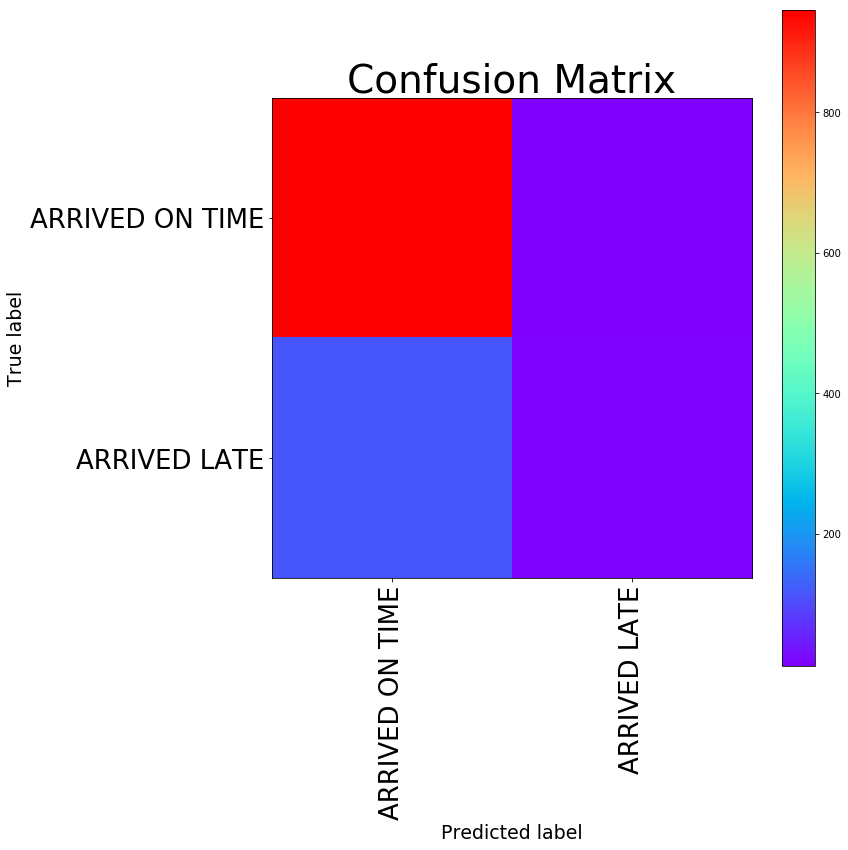

In [93]:
#Generate a confusion matrix for your model
print("Confusion Matrix:")
confusion_matrix = confusion_matrix(test_y, predicted)
print(confusion_matrix)

#Plot confusion matrix
LABELS = ["ARRIVED ON TIME",
         "ARRIVED LATE" ]
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion Matrix", fontsize=39)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, LABELS, fontsize=26, rotation=90)
plt.yticks(tick_marks, LABELS, fontsize=26)
plt.tight_layout()
plt.ylabel('True label', fontsize=19)
plt.xlabel('Predicted label', fontsize=19)
plt.show()

#Note : If you get an error when you run this cell...
#Make sure to rerun the cell where we import the libraries then rerun this ceel

## Visualize Output of Model
Note that at the beginning of the notebook we configured the notebook to support inline Matplotlib output.

In [ ]:
#Configure Seaborn to enhance the output from Matplotlib.
sns.set()

#Plot the ROC curve for the model
fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The dotted line in the middle of the graph represents a 50-50 chance of obtaining a correct answer while blue curve represents the accuracy of our model.

In [74]:
#Function that calls the model 
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

This function takes as input a date (dd/mm/year) and time, an origin airport code, and a destination airport code, and returns a value between 0.0-1.0 indicating the probability that the flight will arrive at its destination on time.

**Now let's analyze some flights**

In [69]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')


0.8

In [77]:
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.8

In [76]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

0.7

### Some more vizualization
Let's plot the probability of on-time arrivals for an evening flight from JFK to ATL over a range of days

(0.0, 1.0)

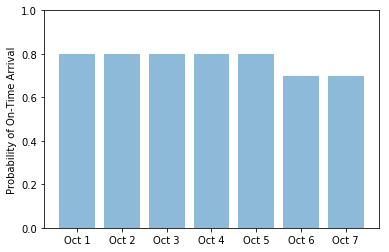

In [78]:
labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

You can modify the code to produce a similar chart for different flights